In [1]:
import numpy as np
from setup_mnist import *
from keras.models import Input, Model
from keras.layers import Average
import tensorflow as tf
from noise_functions_dl import GradientDescentDL, gradientDescentFunc
from functools import partial
from mwu import adversary
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = MNIST()
X_exp = np.load("multiclass_data_2/X_exp.npy")
Y_exp = np.load("multiclass_data_2/Y_exp.npy")
Target_exp = np.load("multiclass_data_2/Target_exp.npy")

In [3]:
X_exp = X_exp.reshape(-1, 28, 28, 1)
Y_exp = np.array([(np.arange(10) == l).astype(np.float32) for l in Y_exp])
Target_exp = np.array([(np.arange(10) == l).astype(np.float32) for l in Target_exp])

In [6]:
def ensembleModels(models, model_input):
    # taken from https://medium.com/@twt446/ensemble-and-store-models-in-keras-2-x-b881a6d7693f
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models] 
    # averaging outputs
    yAvg=Average()(yModels) 
    # build model from same input and avg output
    modelEns = Model(inputs=model_input, outputs=yAvg, name='ensemble')  
    return modelEns

In [7]:
model_dir = "deep_networks"
models = [conv_net(False, 2, 200, model_dir + "/conv0"), conv_net(True, 2, 200, model_dir + "/conv1"), 
          conv_net(True, 4, 64, model_dir + "/conv2"), multilayer(4, 128, model_dir + "/mlp0"),
          multilayer(2, 256, model_dir + "/mlp1")]

In [65]:
[model.evaluate(data.test_data, data.test_labels) for model in models]

10000/10000 [==============================] - 1s 67us/step


[[0.0576457683640132, 0.9874],
 [0.03487977762353567, 0.992],
 [0.034175702735514325, 0.9932],
 [0.1319694802839309, 0.9614],
 [0.07794954743353882, 0.9757]]

In [6]:
[model.evaluate(X_exp, Y_exp) for model in models]

100/100 [==============================] - 0s 522us/step


[[0.0007815231964968916, 1.0],
 [0.0009589233167935163, 1.0],
 [9.794235913432203e-05, 1.0],
 [0.00961893867701292, 1.0],
 [0.008963608406484127, 1.0]]

In [7]:
alpha = 2.8
lr = .001
opt_iters=3000

with tf.Session() as sess:
    
    model_dir = "deep_networks"
    models = [conv_net(False, 2, 200, model_dir + "/conv0"), conv_net(True, 2, 200, model_dir + "/conv1"), 
              conv_net(True, 4, 64, model_dir + "/conv2"), multilayer(4, 128, model_dir + "/mlp0"),
              multilayer(2, 256, model_dir + "/mlp1")]
    model_input = Input(shape=models[0].input_shape[1:])
    ensemble = ensembleModels(models, model_input)
    ensemble.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    print [model.evaluate(X_exp, Y_exp) for model in models]
    print ensemble.evaluate(X_exp, Y_exp)
    attack_obj = GradientDescentDL(sess, [ensemble], alpha, (28, 1, 10), (-.5, .5), 
                                   targeted=False, batch_size=1, max_iterations=opt_iters,
                                   learning_rate=lr, confidence=0)
    
    noise_func = partial(gradientDescentFunc, attack=attack_obj)
    
    V = adversary(np.array([1.0]), [ensemble], X_exp, Y_exp, alpha, noise_func, False)

100/100 [==============================] - 0s 858us/step
[[0.0007815231964968916, 1.0], [0.0009589233167935163, 1.0], [9.794235913432203e-05, 1.0], [0.00961893867701292, 1.0], [0.008963608406484127, 1.0]]
100/100 [==============================] - 0s 3ms/step
[0.00391148978844285, 1.0]


In [8]:
np.save("ensemble_sol_mnist_dl_untargeted_2_8.npy", V)

In [56]:
model_dir = "deep_networks"
models = [conv_net(False, 2, 200, model_dir + "/conv0"), conv_net(True, 2, 200, model_dir + "/conv1"), 
          conv_net(True, 4, 64, model_dir + "/conv2"), multilayer(4, 128, model_dir + "/mlp0"),
          multilayer(2, 256, model_dir + "/mlp1")]

In [70]:
ensemble_noise_ut = np.load("ensemble_sol_mnist_dl_untargeted_2_8.npy")

In [94]:
ensemble_res_ut_full = [model.evaluate(X_exp + ensemble_noise_ut, Y_exp)[1] for model in models]

100/100 [==============================] - 0s 141us/step


In [98]:
ensemble_res_ut_full

[0.79, 0.79, 0.87, 0.05, 0.11]

In [95]:
ensemble_res_ut = max(ensemble_res_ut_full)

In [74]:
ensemble_res_ut

0.87

Ensemble Baseline is .87

In [15]:
alpha = 2.8
lr = .001
opt_iters=3000
with tf.Session() as sess:
    
    model_dir = "deep_networks"
    models = [conv_net(False, 2, 200, model_dir + "/conv0"), conv_net(True, 2, 200, model_dir + "/conv1"), 
              conv_net(True, 4, 64, model_dir + "/conv2"), multilayer(4, 128, model_dir + "/mlp0"),
              multilayer(2, 256, model_dir + "/mlp1")]
    model_input = Input(shape=models[0].input_shape[1:])
    individual_noise = []
    for model in models:
        attack_obj = GradientDescentDL(sess, [model], alpha, (28, 1, 10), (-.5, .5), 
                                       targeted=False, batch_size=1, max_iterations=opt_iters,
                                       learning_rate=lr, confidence=0)
        noise_func = partial(gradientDescentFunc, attack=attack_obj)
        V = adversary(np.array([1.0]), [model], X_exp, Y_exp, alpha, noise_func, False)
        individual_noise.append(V)

In [40]:
np.save("mnist_dl_individual_baselines.npy", np.array(individual_noise))

In [76]:
individual_noise_ut = np.load("mnist_dl_individual_baselines.npy")

In [8]:
best_individual_ut_full = ([([model.evaluate(X_exp + noise, Y_exp)[1] for model in models]) 
                           for noise in individual_noise_ut])

NameError: name 'individual_noise_ut' is not defined

In [88]:
best_individual_ut_full

[[0.36, 1.0, 1.0, 0.99, 1.0],
 [0.99, 0.12, 1.0, 0.99, 0.99],
 [0.97, 0.97, 0.3, 0.98, 0.99],
 [1.0, 1.0, 1.0, 0.04, 0.93],
 [1.0, 1.0, 1.0, 0.84, 0.05]]

In [86]:
best_individual_ut = min([max(individual_res) for individual_res in best_individual_ut_full])

In [93]:
best_individual_ut

0.99

Best Individual Model is .99

# Targeted

In [43]:
alpha = 3.0
lr = .001
opt_iters=3000

with tf.Session() as sess:
    model_dir = "deep_networks"
    models = [conv_net(False, 2, 200, model_dir + "/conv0"), conv_net(True, 2, 200, model_dir + "/conv1"), 
              conv_net(True, 4, 64, model_dir + "/conv2"), multilayer(4, 128, model_dir + "/mlp0"),
              multilayer(2, 256, model_dir + "/mlp1")]
    model_input = Input(shape=models[0].input_shape[1:])
    ensemble = ensembleModels(models, model_input)
    ensemble.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    print [model.evaluate(X_exp, Target_exp) for model in models]
    print ensemble.evaluate(X_exp, Target_exp)
    attack_obj = GradientDescentDL(sess, [ensemble], alpha, (28, 1, 10), (-.5, .5), 
                                   targeted=True, batch_size=1, max_iterations=opt_iters,
                                   learning_rate=lr, confidence=0)
    
    noise_func = partial(gradientDescentFunc, attack=attack_obj)
    targeted_ensemble = adversary(np.array([1.0]), [ensemble], X_exp, Y_exp, alpha, noise_func, Target_exp)

100/100 [==============================] - 0s 3ms/step
[[15.556627197265625, 0.0], [15.009902305603028, 0.0], [15.542401428222655, 0.0], [11.18965087890625, 0.0], [13.649660949707032, 0.0]]
100/100 [==============================] - 1s 7ms/step
[11.793057594299317, 0.0]


In [46]:
np.save("ensemble_sol_mnist_dl_targeted_3_0.npy", np.array(targeted_ensemble))

In [10]:
ensemble_noise_t = np.load("ensemble_sol_mnist_dl_targeted_3_0.npy")

In [11]:
ensemble_res_t_full = [model.evaluate(X_exp + ensemble_noise_t, Target_exp)[1] for model in models]

100/100 [==============================] - 0s 515us/step


In [12]:
ensemble_res_t_full

[0.11, 0.09, 0.04, 0.43, 0.44]

In [13]:
ensemble_res_t = min(ensemble_res_t_full)

In [14]:
ensemble_res_t

0.04

Targeted Ensemble Baseline is 0.04

In [53]:
alpha = 3.0
lr = .001
opt_iters=3000
with tf.Session() as sess:
    model_dir = "deep_networks"
    models = [conv_net(False, 2, 200, model_dir + "/conv0"), conv_net(True, 2, 200, model_dir + "/conv1"), 
              conv_net(True, 4, 64, model_dir + "/conv2"), multilayer(4, 128, model_dir + "/mlp0"),
              multilayer(2, 256, model_dir + "/mlp1")]
    individual_noise_targeted = []
    for model in models:
        attack_obj = GradientDescentDL(sess, [model], alpha, (28, 1, 10), (-.5, .5), 
                                       targeted=True, batch_size=1, max_iterations=opt_iters,
                                       learning_rate=lr, confidence=0)
        noise_func = partial(gradientDescentFunc, attack=attack_obj)
        noise = adversary(np.array([1.0]), [model], X_exp, Y_exp, alpha, noise_func, Target_exp)
        individual_noise_targeted.append(noise)

In [55]:
np.save("mnist_dl_individual_baselines_targeted.npy", np.array(individual_noise_targeted))

In [15]:
individual_noise_t = np.load("mnist_dl_individual_baselines_targeted.npy")

In [16]:
individual_noise_t_full = ([([model.evaluate(X_exp + noise, Target_exp)[1] for model in models]) 
                             for noise in individual_noise_t])

100/100 [==============================] - 0s 76us/step


In [17]:
individual_noise_t_full

[[0.4, 0.0, 0.0, 0.0, 0.0],
 [0.01, 0.55, 0.0, 0.0, 0.0],
 [0.01, 0.01, 0.34, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.51, 0.01],
 [0.0, 0.0, 0.0, 0.07, 0.66]]

In [127]:
best_individual_t = max([min(res) for res in individual_noise_t_full])

In [128]:
best_individual_t

0.0

Max_Model baseline is 0 for MNIST

In [109]:
min_acc_t = np.load("deepLearning-mnist-targeted-3.0-2-4-2033/acc_history.npy")

In [20]:
noise_mwu_t = np.load("deepLearning-mnist-targeted-3.0-2-4-2033/noise.npy")

In [23]:
mwu_t_results = [[model.evaluate(X_exp + noise, Target_exp)[1] for model in models] for noise in noise_mwu_t]

100/100 [==============================] - 0s 78us/step


In [24]:
mwu_t_results = np.array(mwu_t_results)

In [26]:
np.mean(mwu_t_results, axis=0)

array([0.2954, 0.3166, 0.2834, 0.4706, 0.4652])

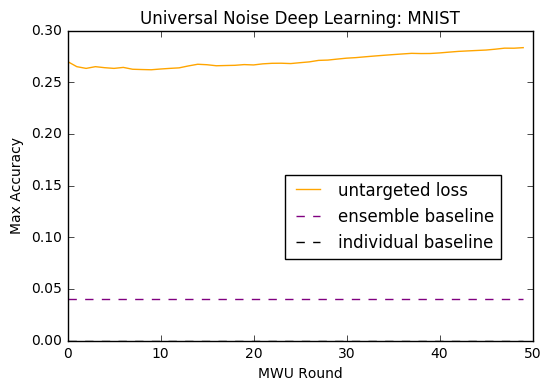

In [129]:
num_iters = 50
plt.plot(range(num_iters), min_acc_t, color="orange")
plt.plot(range(num_iters), [ensemble_res_t] * num_iters, linestyle="--", color="purple")
# plt.plot(range(num_iters), [best_individual_t] * num_iters, linestyle="--", color="black")
plt.legend(["untargeted loss", "ensemble baseline", "individual baseline"], loc="right", 
           bbox_to_anchor=(.95,.4), fontsize=12)
plt.title("Universal Noise Deep Learning: MNIST")
plt.ylabel("Max Accuracy")
plt.xlabel("MWU Round")

# NEed to move these cells up

In [89]:
max_acc_ut = np.load("deepLearning-mnist-untargeted-2.8-2-4-1951/acc_history.npy")

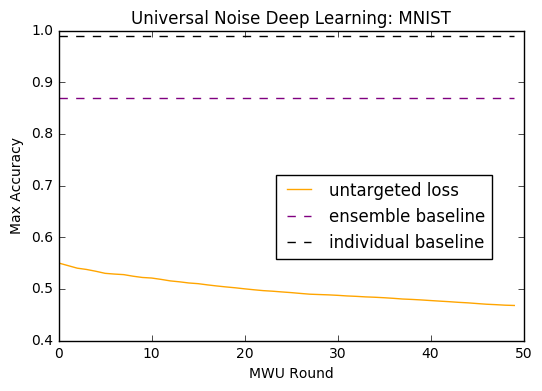

In [97]:
num_iters = 50
ensemble_res = .99
plt.plot(range(num_iters), max_acc_ut, color="orange")
plt.plot(range(num_iters), [ensemble_res_ut] * num_iters, linestyle="--", color="purple")
plt.plot(range(num_iters), [best_individual_ut] * num_iters, linestyle="--", color="black")
plt.legend(["untargeted loss", "ensemble baseline", "individual baseline"], loc="right", 
           bbox_to_anchor=(.95,.4), fontsize=12)
plt.title("Universal Noise Deep Learning: MNIST")
plt.ylabel("Max Accuracy")
plt.xlabel("MWU Round")

In [99]:
mwu_noise = np.load("deepLearning-mnist-untargeted-2.8-2-4-1951/noise.npy")

In [ ]:
mwu_accuracies = [[model.evaluate(X_exp + noise, Y_exp)[1] for model in models] for noise in mwu_noise]

In [101]:
mwu_accuracies = np.array(mwu_accuracies)

In [107]:
np.mean(mwu_accuracies, axis=0)

array([0.4678, 0.3794, 0.4474, 0.1054, 0.1324])